## Levels and Tails

### Summary 

In this note, I lay down a framework for analyzing swap rates levels both in spot and forward space, and rolldown for G3 currencies. I find that:
* In USD swaps, the move over the last 3 months has been an almost parallel rally across the curve in spot space. But when we look at it in forward space, we find some nuances: 
    * 1y2y and 1y3y rallied the most as the market started pricing a deeper cutting cycle in the next 2 years
    * 9y1y and 30y1y rallied more than points around them as investors use those liquid points for long duration hedges  
*	The curve is now overall very flat, though the belly of the curve has slowly steepened over the last 6 months
*	For investors looking to go long rates, the current shape of the curve would favor going long the backend in forward space (e.g. 5y5y) as that’s where there is a slightly favorable rolldown
*	On a comparative basis:
	* the EUR curve is lower and steeper (as front end rates are at the lower bound) making it slightly more attractive from a roll-down perspective (but with less room to rally); and
    * the GBP curve lower but flatter making it a slightly more attractive hedge for a broad duration sell-off



The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Spot Space](#2---Spot-Space)
* [3 - Forward Space](#3---Forward-Space)
* [4 - G3 Rolldown](#4---G3-Rolldown)

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.99.

In [1]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',)) 

### 2 - Spot Space

Let's start by looking at USD spot swap rates accross a range of tails and how current levels compare to 3 and 6 months ago.

In [2]:
from gs_quant.markets import PricingContext
from gs_quant.instrument import IRSwap
from gs_quant.common import PayReceive, Currency
from gs_quant.risk import IRFwdRate
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime as dt
import pandas as pd

def evaluate_with_context(instruments, measure=IRFwdRate, location='NYC', pricing_date=dt.date.today()):
    """evaluates a measure on an iterable of instruments in a pricing context (specific data location and date)"""
    with PricingContext(market_data_location=location, pricing_date=pricing_date):
        calc = [s.calc(measure) for s in instruments]
    return [s.result() for s in calc]

def levels_and_tails(look_back_mo, fwd_points, fixed_on='Tenors', fix_yrs=1, ccy=Currency.USD, p_r=PayReceive.Receive):
    """constructs a swap array w/ varying tenors/effective dates, returns frame evaluated for given lookback periods"""
    swaps = [IRSwap(p_r, '{}y'.format(fix_yrs), ccy, effective_date='{}y'.format(f)) for f in fwd_points] \
        if fixed_on=='Tenors' else [IRSwap(p_r, '{}y'.format(f), ccy, effective_date='{}y'.format(fix_yrs)) 
                                    for f in fwd_points]
    return pd.DataFrame({'{}m ago'.format(m) : 
                             evaluate_with_context(swaps, pricing_date=dt.date.today() + timedelta(weeks=-4*m)) 
                         for m in look_back_mo})*100

[Text(0, 0.5, 'Rate (%)'), Text(0.5, 0, 'Underlying Swap')]

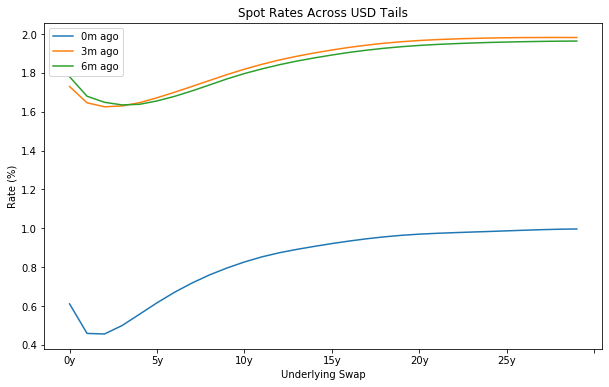

In [3]:
spot = levels_and_tails((0, 3, 6), range(1, 31), fixed_on='Forwards', fix_yrs=0)
spot.set_index([['{}y'.format(t) for t in spot.index]], inplace=True)
ax = spot.plot(figsize=(10, 6), title='Spot Rates Across USD Tails')
ax.set(ylabel='Rate (%)', xlabel='Underlying Swap')

As we can see in the graph, swap rates have come in vs 3m ago but are higher than 6mo for tails longer than 2y. Let's visualize the difference for each tenor using a bar chart.

[Text(0, 0.5, 'Rate (%)'), Text(0.5, 0, 'Underlying Swap')]

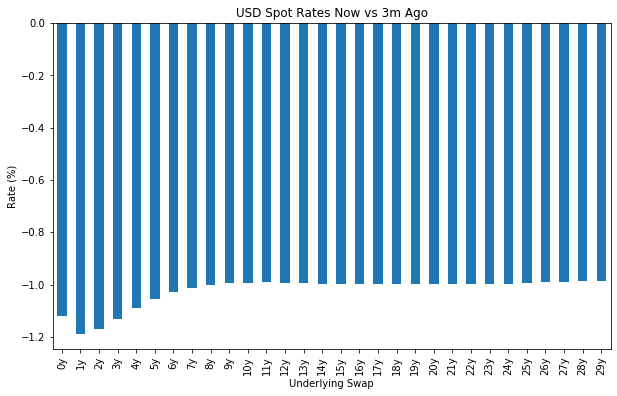

In [4]:
ax = (spot['0m ago']-spot['3m ago']).plot(figsize=(10, 6), kind='bar', title='USD Spot Rates Now vs 3m Ago')
ax.set(ylabel='Rate (%)', xlabel='Underlying Swap')

As we can see, compared to 3 months ago, swap rates have come in by ~18bps for all tails > 2y. 

[Text(0, 0.5, 'Rate (%)'), Text(0.5, 0, 'Underlying Swap')]

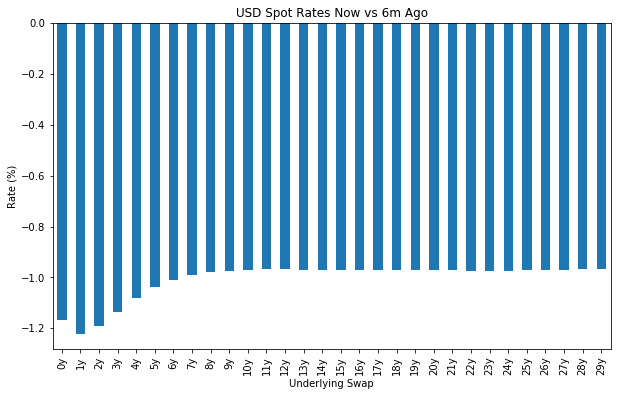

In [5]:
ax = (spot['0m ago']-spot['6m ago']).plot(figsize=(10, 6), kind='bar', title='USD Spot Rates Now vs 6m Ago')
ax.set(ylabel='Rate (%)', xlabel='Underlying Swap')

But compared to 6 months ago, swap rates are higher by ~5-10bps except at tails <3y where they are lower.

### 3 - Forward Space

Let's look at how spot space compared to forward 1y space (we can use the same function to look at any 
point).

[Text(0, 0.5, 'Rate (%)'), Text(0.5, 0, 'Underlying Swap')]

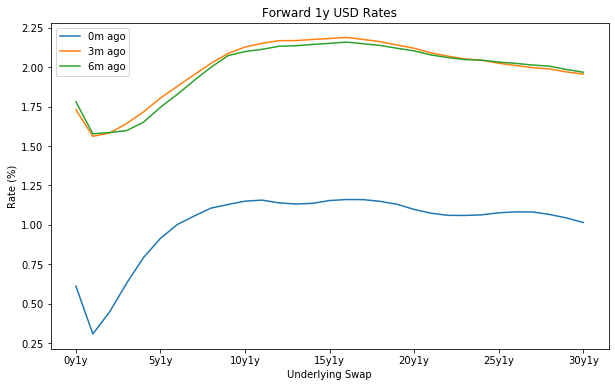

In [6]:
forward = levels_and_tails((0, 3, 6), range(0, 31), fixed_on='Tenors', fix_yrs=1)
forward.set_index([['{}y1y'.format(t) for t in forward.index]], inplace=True)
ax = forward.plot(figsize=(10, 6), title='Forward 1y USD Rates')
ax.set(ylabel='Rate (%)', xlabel='Underlying Swap')

We see a similiar comparative shift in the forward space - rates are higher vs 6m but lower vs 3m. We can also visualize where the best rolldown might be - more on this later. Let's first look if the changes are consistent across different tails.

[Text(0, 0.5, 'Rate (%)'), Text(0.5, 0, 'Underlying Swap')]

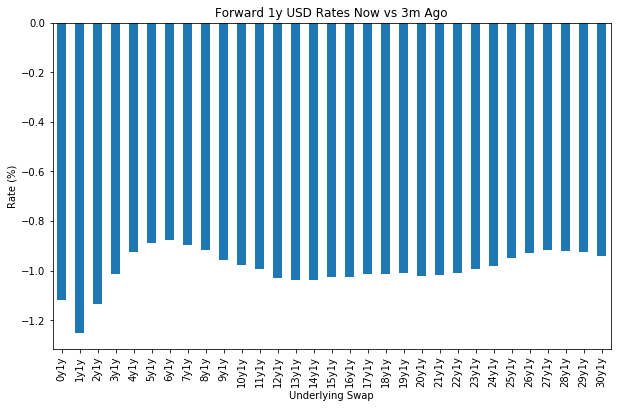

In [7]:
ax = (forward['0m ago']-forward['3m ago']).plot(figsize=(10, 6), kind='bar', title='Forward 1y USD Rates Now vs 3m Ago')
ax.set(ylabel='Rate (%)', xlabel='Underlying Swap')

Unlike in the spot space, 1y forward changes are less consistent across tenors - biggest changes vs 3 months ago are 2y, 9y and 30y tails.

[Text(0, 0.5, 'Rate (%)'), Text(0.5, 0, 'Underlying Swap')]

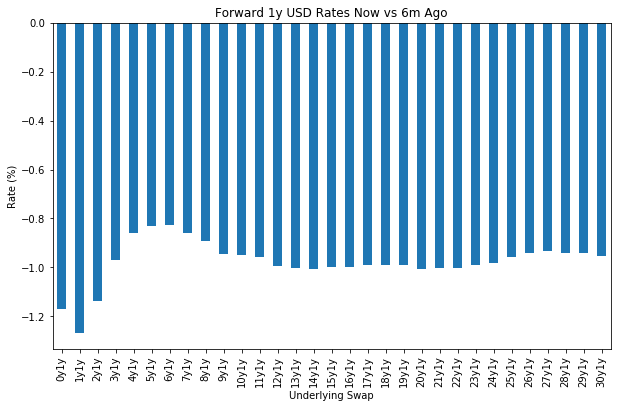

In [8]:
ax = (forward['0m ago']-forward['6m ago']).plot(figsize=(10, 6), kind='bar', title='Forward 1y USD Rates Now vs 6m Ago')
ax.set(ylabel='Rate (%)', xlabel='Underlying Swap')

Compared to 6 months ago, the biggest change is for 4y tails - for longer tails the change falls off almost monotonically.

Let's now take a look at where rates are for a number of forward points and tails.

In [9]:
from gs_quant.risk import CarryScenario
from copy import deepcopy
import seaborn as sns

# note, if using pandas version>1.0.0, please delete result_type='broadcast' and replace last line with
# return df.apply(lambda x: evaluate_with_context(x, IRFwdRate, location), axis=1)
def construct_swap_frame(frame, ccy=Currency.USD, with_rolldown=False, carry_months=3, location='NYC', p_r=PayReceive.Receive):
    """constructs swap frame with option to subtract carry months from effective date and evaluates with pricing context"""
    df = frame.apply(lambda x: [ IRSwap(p_r, termination_date='{}m'.format(tenor), notional_currency=ccy, 
                                        effective_date='{}m'.format(x.name-carry_months if with_rolldown else x.name)) 
                                for tenor in x.index], axis=1, result_type='broadcast')
    return df.apply(lambda x: evaluate_with_context(x, IRFwdRate, location))

def styled_heatmap(frame, title=''):
    """styles heatmap by adding labels and centering colors around 0"""
    df = deepcopy(frame)*100
    df.columns = ['{}m'.format(t) if t < 12 else '{}y'.format(int(t/12)) for t in df.columns]
    df.set_index([['{}m'.format(t) if t < 12 else '{}y'.format(int(t/12)) for t in df.index]], inplace=True)
    limit = max(abs(min(df.min())), abs(max(df.max())))
    plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(df, annot=True, fmt='.2f', cmap='coolwarm_r', vmin=-limit, vmax=limit)
    ax.set(ylabel='Forward Start', xlabel='Tenor', title=title)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

In [10]:
swap_df = pd.DataFrame(index=(3, 6, 9, 12, 24, 36, 60, 120), columns=(6, 12, 24, 36, 48, 60, 72, 84, 120, 180, 240)) 
usd_spot = construct_swap_frame(swap_df, Currency.USD)

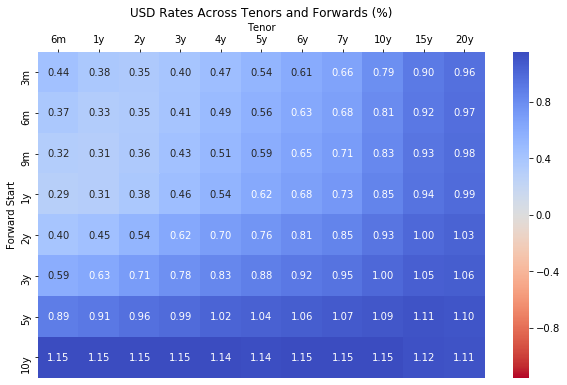

In [11]:
styled_heatmap(usd_spot, title='USD Rates Across Tenors and Forwards (%)')

Unsurprsingly, rates are lowest at the front of the curve for shorter forward starts and higher at the longer tails. 

### 4 - G3 Rolldown

Let's now look at where the best 3m rolldown opportunities might be by looking a simple roll to spot scenario - more on advanced carry scenarios in later publications.

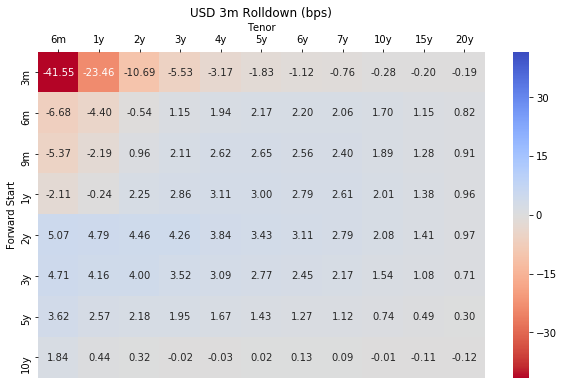

In [12]:
usd_rd = construct_swap_frame(swap_df, Currency.USD, with_rolldown=True, carry_months=3)
styled_heatmap((usd_spot-usd_rd)*100, title='USD 3m Rolldown (bps)')

As we can see, in line with the curves above, there is negative at the front of the USD curve especially for tails and forward points <2y. The best positive rolldown here is at 5y starting point across shorter tenors (<2y). Let's now compare this to EUR and GBP.

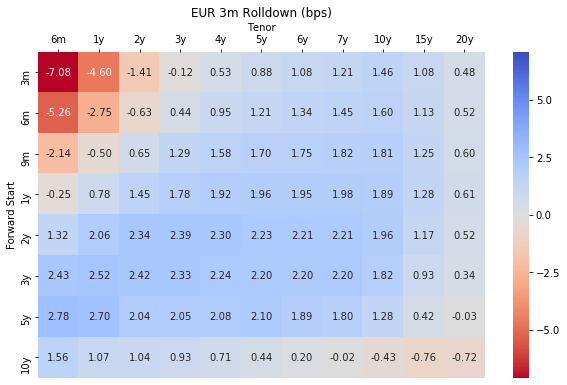

In [13]:
eur_spot = construct_swap_frame(swap_df, Currency.EUR)
eur_rd = construct_swap_frame(swap_df, Currency.EUR, with_rolldown=True, carry_months=3)
styled_heatmap((eur_spot-eur_rd)*100, title='EUR 3m Rolldown (bps)')

The big picture for EUR is largely similar but the negative rolldown is smaller at the front of the curve and the best positive rolldown is still 5y starting but for 3y, 4y and 5y tails.

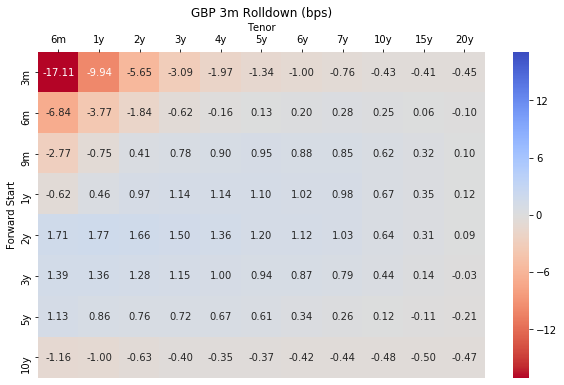

In [14]:
gbp_spot = construct_swap_frame(swap_df, Currency.GBP)
gbp_rd = construct_swap_frame(swap_df, Currency.GBP, with_rolldown=True, carry_months=3)
styled_heatmap((gbp_spot-gbp_rd)*100, title='GBP 3m Rolldown (bps)')

The negative rolldown for GBP is lower than for EUR but higher than for USD. The best positive rolldown is at 2y forward start for 6m and 1y tenors.

### Disclaimer
This website may contain links to websites and the content of third parties ("Third Party Content"). We do not monitor, review or update, and do not have any control over, any Third Party Content or third party websites. We make no representation, warranty or guarantee as to the accuracy, completeness, timeliness or reliability of any Third Party Content and are not responsible for any loss or damage of any sort resulting from the use of, or for any failure of, products or services provided at or from a third party resource. If you use these links and the Third Party Content, you acknowledge that you are doing so entirely at your own risk.